In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


   CustomerID  Recency  Frequency  Monetary           AOV  Tenure
0     12346.0      326          1  77183.60  77183.600000       0
1     12347.0        2          7   4310.00    615.714286     365
2     12348.0       75          4   1797.24    449.310000     282
3     12349.0       19          1   1757.55   1757.550000       0
4     12350.0      310          1    334.40    334.400000       0


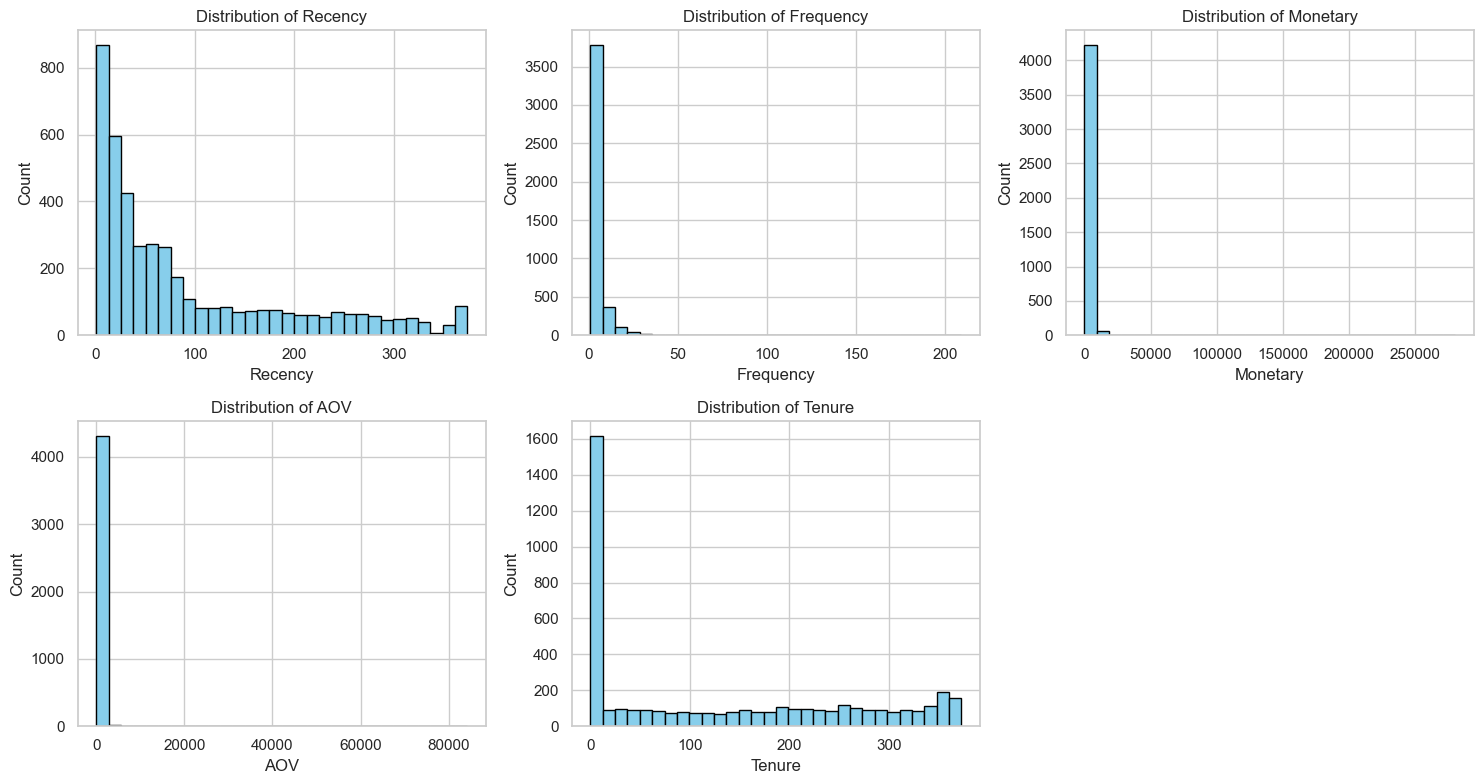

In [3]:
rfm_df = pd.read_csv('rfm_features.csv')

# Display first few rows
print(rfm_df.head())

# Select numeric columns (exclude CustomerID)
numeric_cols = ['Recency', 'Frequency', 'Monetary', 'AOV', 'Tenure']

# Plot histograms
plt.figure(figsize=(15,8))


for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(rfm_df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.savefig("data_skew.png")
plt.show()

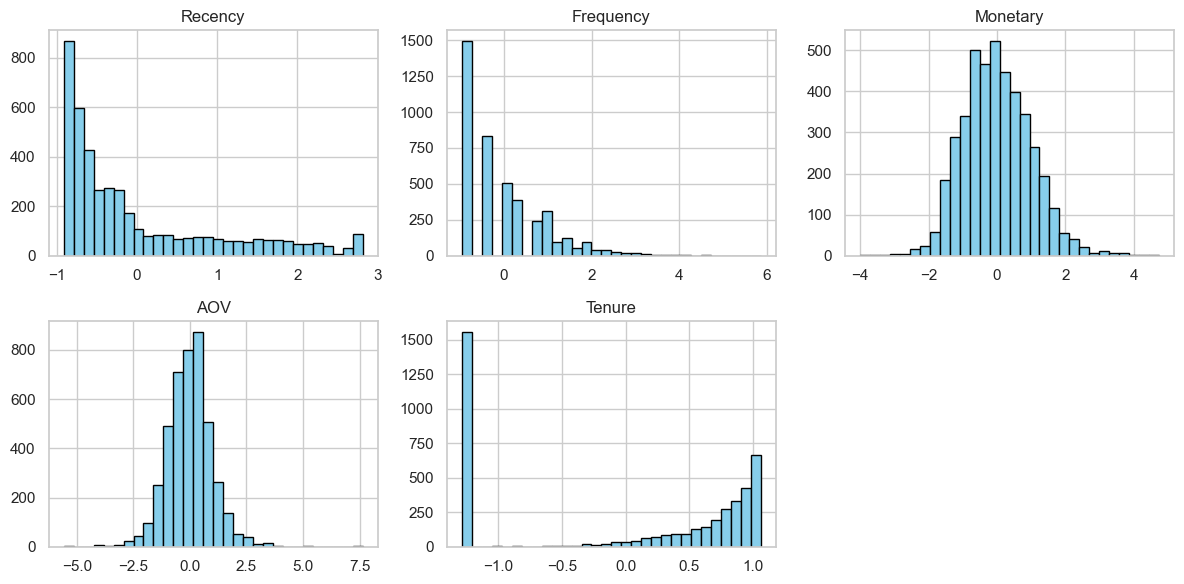

In [5]:
# Select features for clustering
features = ['Recency', 'Frequency', 'Monetary', 'AOV', 'Tenure']

# 1️⃣ Apply log1p transform to skewed features
# Recency might be okay, but Monetary, AOV, Tenure are usually skewed
rfm_log = rfm_df.copy()
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])
rfm_log['AOV'] = np.log1p(rfm_log['AOV'])
rfm_log['Tenure'] = np.log1p(rfm_log['Tenure'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])  # optional

# 2️⃣ Scale features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[features])

# Convert back to DataFrame for convenience
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=features)
rfm_scaled_df['CustomerID'] = rfm_log['CustomerID'].values
plt.figure(figsize=(12,6))
for i, col in enumerate(features):
    plt.subplot(2, 3, i+1)
    plt.hist(rfm_scaled_df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
plt.tight_layout()
plt.savefig("data_transformed.png")
plt.show()



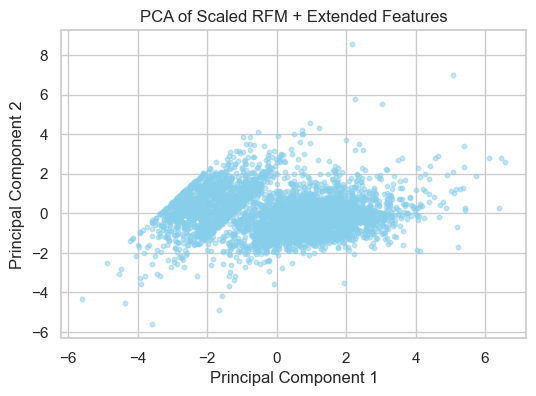

In [7]:
features = ['Recency', 'Frequency', 'Monetary', 'AOV', 'Tenure']
X_scaled = rfm_scaled_df[features].values

# PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['CustomerID'] = rfm_scaled_df['CustomerID'].values

# Scatter plot
plt.figure(figsize=(6,4))
plt.scatter(pca_df['PC1'], pca_df['PC2'], s=10, alpha=0.5, color='skyblue')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Scaled RFM + Extended Features')
plt.savefig("PCA.png")
plt.show()

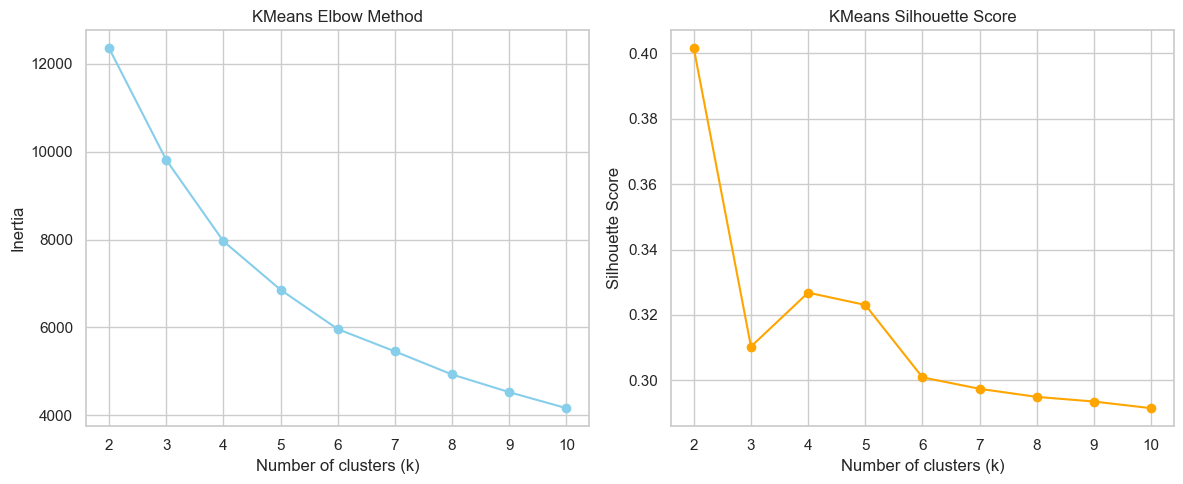

Optimal number of clusters for KMeans: 2
KMeans silhouette score at optimal k: 0.4015


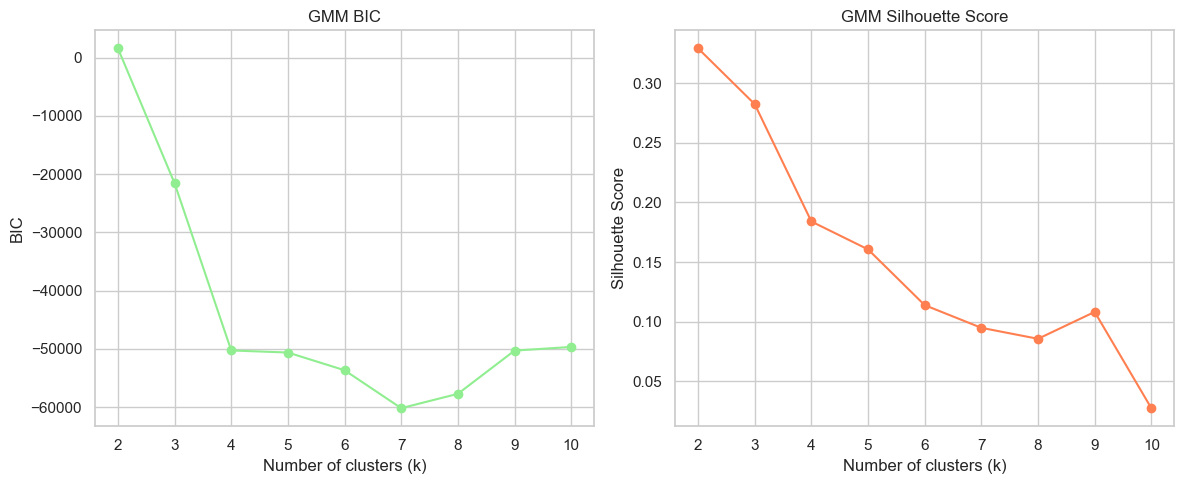

Optimal number of clusters for GMM: 7
GMM silhouette score at optimal k: 0.0948


In [8]:
# Features to cluster
features = ['Recency', 'Frequency', 'Monetary', 'AOV', 'Tenure']
X = rfm_scaled_df[features].values

# -------------------------------
# 1️⃣ KMeans: Elbow + Silhouette
# -------------------------------
inertia = []
sil_scores = []
K_range = range(2, 11)  # trying k=2 to k=10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X, labels))

# Plot Elbow
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'o-', color='skyblue')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('KMeans Elbow Method')

# Plot Silhouette
plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, 'o-', color='orange')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score')
plt.tight_layout()
plt.savefig("Kmeans.png")
plt.show()

# Optimal k for KMeans (highest silhouette)
optimal_k = K_range[np.argmax(sil_scores)]
print(f"Optimal number of clusters for KMeans: {optimal_k}")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans_final.fit_predict(X)
print(f"KMeans silhouette score at optimal k: {silhouette_score(X, kmeans_labels):.4f}")

# -------------------------------
# 2️⃣ GMM: BIC + Silhouette
# -------------------------------
bic = []
sil_scores_gmm = []

for k in K_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm_labels = gmm.fit_predict(X)
    bic.append(gmm.bic(X))
    sil_scores_gmm.append(silhouette_score(X, gmm_labels))

# Plot BIC
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, bic, 'o-', color='lightgreen')
plt.xlabel('Number of clusters (k)')
plt.ylabel('BIC')
plt.title('GMM BIC')

# Plot Silhouette
plt.subplot(1,2,2)
plt.plot(K_range, sil_scores_gmm, 'o-', color='coral')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('GMM Silhouette Score')
plt.tight_layout()
plt.savefig("GMM.png")
plt.show()

# Optimal k for GMM (lowest BIC)
optimal_k_gmm = K_range[np.argmin(bic)]
gmm_final = GaussianMixture(n_components=optimal_k_gmm, covariance_type='full', random_state=42)
gmm_labels_final = gmm_final.fit_predict(X)
print(f"Optimal number of clusters for GMM: {optimal_k_gmm}")
print(f"GMM silhouette score at optimal k: {silhouette_score(X, gmm_labels_final):.4f}")


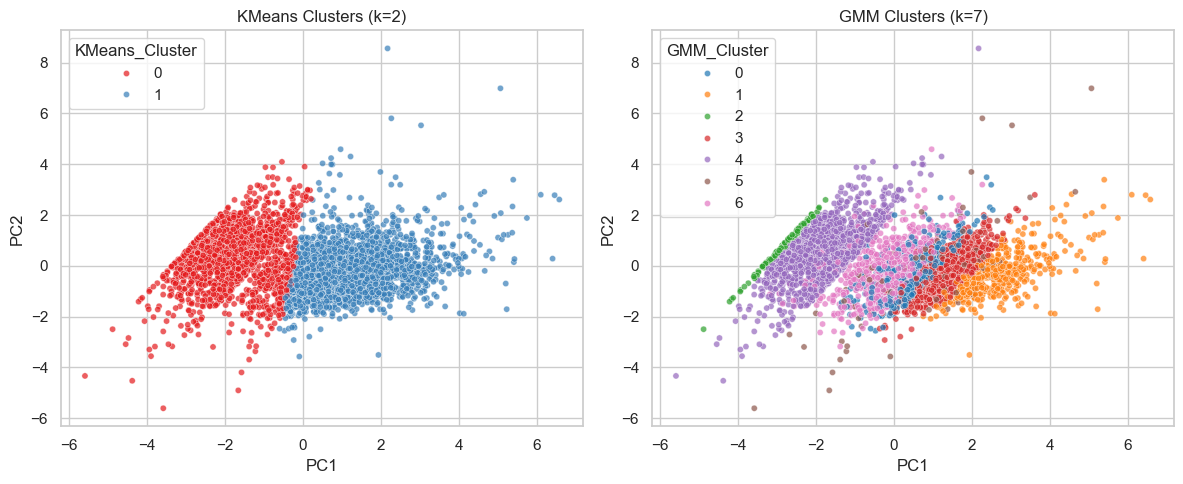

Percentage of customers in each cluster:
   KMeans_%Customers  GMM_%Customers
0               43.2           11.53
1               56.8           11.78
2                NaN            2.37
3                NaN           20.72
4                NaN           32.04
5                NaN            2.40
6                NaN           19.16


In [9]:
# -------------------------------
# Prepare PCA
# -------------------------------
features = ['Recency', 'Frequency', 'Monetary', 'AOV', 'Tenure']
X = rfm_scaled_df[features].values

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['CustomerID'] = rfm_scaled_df['CustomerID'].values

# -------------------------------
# Add cluster labels
# -------------------------------
pca_df['KMeans_Cluster'] = kmeans_labels
pca_df['GMM_Cluster'] = gmm_labels_final

# -------------------------------
# Plot KMeans clusters
# -------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(
    x='PC1', y='PC2',
    hue='KMeans_Cluster',
    palette='Set1',
    data=pca_df,
    legend='full',
    s=20,
    alpha=0.7
)
plt.title('KMeans Clusters (k=2)')

# Plot GMM clusters
plt.subplot(1,2,2)
sns.scatterplot(
    x='PC1', y='PC2',
    hue='GMM_Cluster',
    palette='tab10',
    data=pca_df,
    legend='full',
    s=20,
    alpha=0.7
)
plt.title('GMM Clusters (k=7)')

plt.tight_layout()
plt.savefig("pca_clustered.png")
plt.show()

# -------------------------------
# Percentage of customers in each cluster
# -------------------------------
kmeans_counts = pca_df['KMeans_Cluster'].value_counts(normalize=True) * 100
gmm_counts = pca_df['GMM_Cluster'].value_counts(normalize=True) * 100

cluster_table = pd.DataFrame({
    'KMeans_%Customers': kmeans_counts.round(2),
    'GMM_%Customers': gmm_counts.round(2)
}).sort_index()

print("Percentage of customers in each cluster:")
print(cluster_table)


In [10]:
# Copy original RFM dataframe
rfm_clustered = rfm_df.copy()

# Add GMM cluster labels
rfm_clustered['GMM_Cluster'] = gmm_labels_final

# Compute average metrics per cluster
cluster_summary = rfm_clustered.groupby('GMM_Cluster')[['Recency','Frequency','Monetary','AOV','Tenure']].mean().round(2)

# Add count and percentage of customers per cluster
cluster_summary['CustomerCount'] = rfm_clustered.groupby('GMM_Cluster')['CustomerID'].count()
cluster_summary['CustomerPct'] = (cluster_summary['CustomerCount'] / rfm_clustered.shape[0] * 100).round(2)

# Reset index for cleaner display
cluster_summary = cluster_summary.reset_index()

print("GMM Cluster Profiling:")
print(cluster_summary)


GMM Cluster Profiling:
   GMM_Cluster  Recency  Frequency  Monetary      AOV  Tenure  CustomerCount  \
0            0    70.26       3.00   1102.58   367.53  164.07            500   
1            1    14.78      16.74   9482.13   467.68  325.71            511   
2            2   366.91       1.00    239.79   239.79    0.00            103   
3            3    37.70       5.08   1939.87   378.85  234.41            899   
4            4   141.10       1.00    423.95   423.95    0.00           1390   
5            5   122.09       7.27   5420.59  1442.20  125.31            104   
6            6    94.13       2.00    684.57   342.29  112.69            831   

   CustomerPct  
0        11.53  
1        11.78  
2         2.37  
3        20.72  
4        32.04  
5         2.40  
6        19.16  


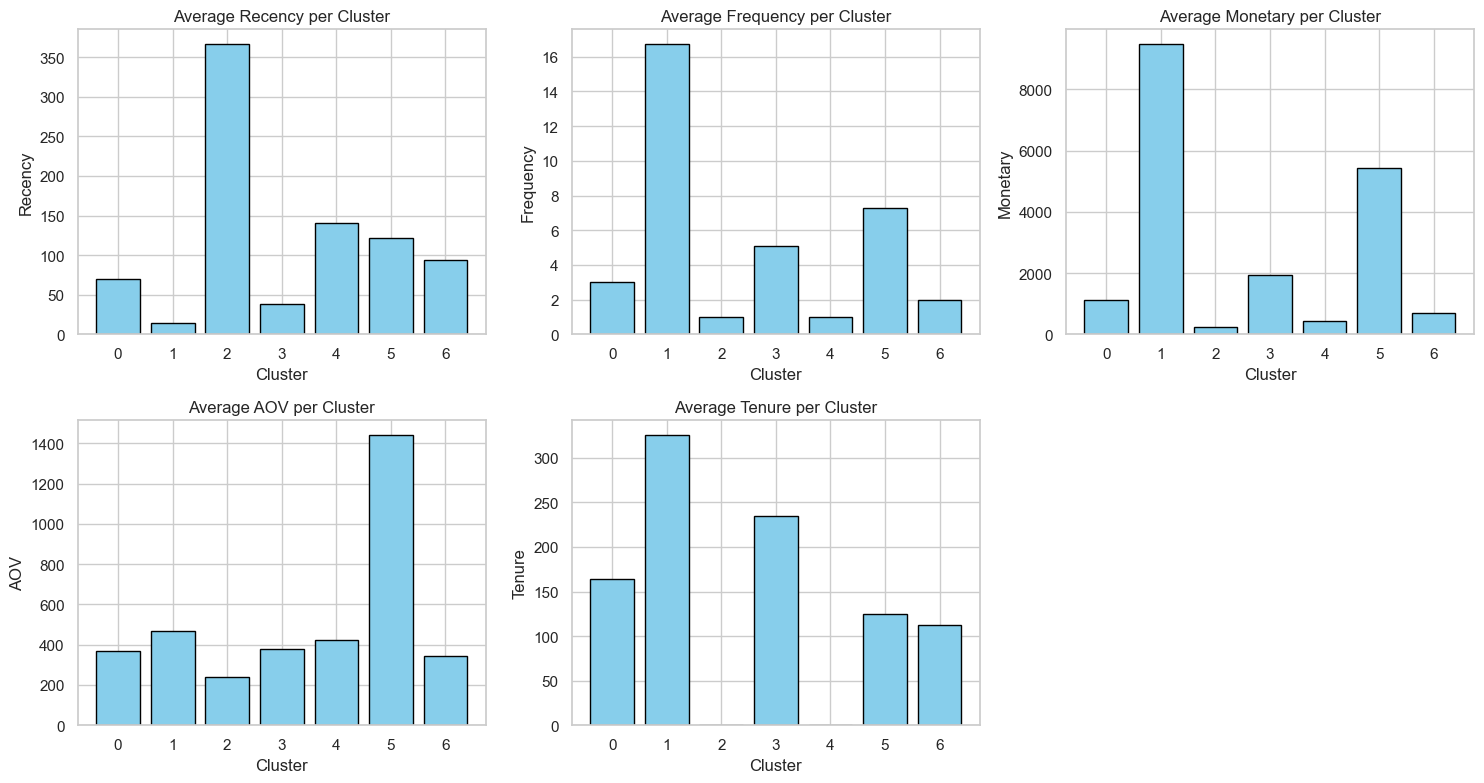

In [12]:

metrics = ['Recency','Frequency','Monetary','AOV','Tenure']
cluster_ids = cluster_summary['GMM_Cluster']

plt.figure(figsize=(15,8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    plt.bar(cluster_ids, cluster_summary[metric], color='skyblue', edgecolor='black')
    plt.xlabel('Cluster')
    plt.ylabel(metric)
    plt.title(f'Average {metric} per Cluster')
plt.tight_layout()
plt.savefig("cluster_summary.png")
plt.show()

In [23]:
df = pd.read_csv('data_preprocessed.csv', parse_dates=['InvoiceDate'])


#Filter first 8 months for feature calculation
cut_off = df['InvoiceDate'].min() + pd.DateOffset(months=8)
df_first8 = df[df['InvoiceDate'] <= cut_off].copy()
today = df_first8['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm_features = df_first8.groupby('CustomerID').agg({
    'InvoiceDate': [np.min, np.max],           # first and last purchase
    'InvoiceNo': pd.Series.nunique,           # frequency = number of unique invoices
    'Revenue': 'sum'
})

# Flatten MultiIndex columns
rfm_features.columns = ['FirstPurchase', 'LastPurchase', 'Frequency', 'Monetary']

# Recency, AOV, Tenure
rfm_features['Recency'] = (today - rfm_features['LastPurchase']).dt.days
rfm_features['AOV'] = rfm_features['Monetary'] / rfm_features['Frequency']
rfm_features['Tenure'] = (rfm_features['LastPurchase'] - rfm_features['FirstPurchase']).dt.days

# Reset index
rfm_features = rfm_features.reset_index()
rfm_features = rfm_features[['CustomerID','Recency','Frequency','Monetary','AOV','Tenure']]
for col in ['Recency','Frequency','Monetary','AOV','Tenure']:
    rfm_features[col] = np.log1p(rfm_features[col])


#  Scale numeric features

features = ['Recency','Frequency','Monetary','AOV','Tenure']
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features[features])


# Calculating the actual CLV for next 4 months

future_start = df['InvoiceDate'].min() + pd.DateOffset(months=8)  # month 9
future_end = df['InvoiceDate'].max()                                # last month

df_future = df[(df['InvoiceDate'] > future_start) & (df['InvoiceDate'] <= future_end)].copy()


# Aggregate future revenue per customer

future_clv = df_future.groupby('CustomerID')['Revenue'].sum().reset_index()
future_clv.rename(columns={'Revenue':'FutureCLV'}, inplace=True)


#  Merge with RFM features

rfm_features = rfm_features.merge(future_clv, on='CustomerID', how='left')

# Fill customers with no purchases in future period with 0
rfm_features['FutureCLV'] = rfm_features['FutureCLV'].fillna(0)

num_zero = (rfm_features['FutureCLV'] == 0).sum()

# Total rows
total_rows = rfm_features.shape[0]

# Percentage
percent_zero = (num_zero / total_rows) * 100

print(f"Percentage of customers with FutureCLV = 0: {percent_zero:.2f}%")
print(rfm_features.head())


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4452\1782895019.py:9: FutureWarning: The provided callable <function min at 0x0000017924D1E8C0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  rfm_features = df_first8.groupby('CustomerID').agg({
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4452\1782895019.py:9: FutureWarning: The provided callable <function max at 0x0000017924D1E7A0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  rfm_features = df_first8.groupby('CustomerID').agg({


Percentage of customers with FutureCLV = 0: 36.53%
   CustomerID   Recency  Frequency   Monetary        AOV    Tenure  FutureCLV
0     12346.0  5.278115   0.693147  11.253955  11.253955  0.000000       0.00
1     12347.0  3.988984   1.609438   7.699367   6.314431  5.214936    2104.05
2     12348.0  4.779123   1.386294   7.305349   6.208080  4.700480     310.00
3     12350.0  5.198497   0.693147   5.815324   5.815324  0.000000       0.00
4     12352.0  4.882802   1.791759   7.354241   5.747359  3.555348     944.23


In [19]:
# Features and Target
numeric_cols = ['Recency','Frequency','Monetary','AOV','Tenure']
X_xgb= pd.DataFrame(rfm_scaled, columns=['Recency','Frequency','Monetary','AOV','Tenure'])
X_xgb = X_xgb[numeric_cols]
y = rfm_features['FutureCLV']


#  Train/Test Split

X_xgb_train, X_xgb_test, y_train, y_test = train_test_split(
    X_xgb, y, test_size=0.2, random_state=42
)


# Evaluation Function
def evaluate_model(model, X_tr, y_tr, X_te, y_te):
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)
    metrics = pd.DataFrame({
        'Dataset': ['Train', 'Test'],
        'R2': [r2_score(y_tr, y_pred_tr), r2_score(y_te, y_pred_te)],
        'RMSE': [np.sqrt(mean_squared_error(y_tr, y_pred_tr)),
                 np.sqrt(mean_squared_error(y_te, y_pred_te))]
    })
    return metrics


# Models

# Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_xgb_train, y_train)
metrics_lin = evaluate_model(lin_model, X_xgb_train, y_train, X_xgb_test, y_test)
metrics_lin['Model'] = 'Linear Regression'

# Random Forest Regressor with GridSearch
rf = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [6, 10],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(rf, rf_param_grid, scoring='r2', cv=3, n_jobs=-1, verbose=1)
rf_grid.fit(X_xgb_train, y_train)
best_rf = rf_grid.best_estimator_
metrics_rf = evaluate_model(best_rf, X_xgb_train, y_train, X_xgb_test, y_test)
metrics_rf['Model'] = 'Random Forest'

# Gradient Boosting Regressor
gb = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    'n_estimators': [200, 500],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(gb, gb_param_grid, scoring='r2', cv=3, n_jobs=-1, verbose=1)
gb_grid.fit(X_xgb_train, y_train)
best_gb = gb_grid.best_estimator_
metrics_gb = evaluate_model(best_gb, X_xgb_train, y_train, X_xgb_test, y_test)
metrics_gb['Model'] = 'Gradient Boosting'

# XGBoost Regressor
xgb = XGBRegressor(random_state=42, n_estimators=500, verbosity=0)
xgb_param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb, xgb_param_grid, scoring='r2', cv=3, n_jobs=-1, verbose=1)
xgb_grid.fit(X_xgb_train, y_train, eval_set=[(X_xgb_test, y_test)], verbose=False)
best_xgb = xgb_grid.best_estimator_
metrics_xgb = evaluate_model(best_xgb, X_xgb_train, y_train, X_xgb_test, y_test)
metrics_xgb['Model'] = 'XGBoost'

#  Combine Results

results = pd.concat([metrics_lin, metrics_rf, metrics_gb, metrics_xgb], ignore_index=True)
results = results[['Model','Dataset','R2','RMSE']]
print(results)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
               Model Dataset        R2         RMSE
0  Linear Regression   Train  0.156043  5415.153138
1  Linear Regression    Test  0.207116  5100.519936
2      Random Forest   Train  0.821669  2489.222865
3      Random Forest    Test  0.610622  3574.333785
4  Gradient Boosting   Train  0.985932   699.155834
5  Gradient Boosting    Test  0.930962  1505.064164
6            XGBoost   Train  0.993770   465.249582
7            XGBoost    Test  0.926871  1549.010453


C:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


   GMM_Cluster     Total_CLV  Revenue_per_Person  Pct_Contribution
0            0  5.284750e+05         1056.949998              6.24
1            1  4.536884e+06         8878.443202             53.59
2            2  1.902381e+04          184.697172              0.22
3            3  1.931068e+06         2148.017632             22.81
4            4  4.972330e+05          357.721605              5.87
5            5  4.036891e+05         3881.625574              4.77
6            6  5.500139e+05          661.869860              6.50


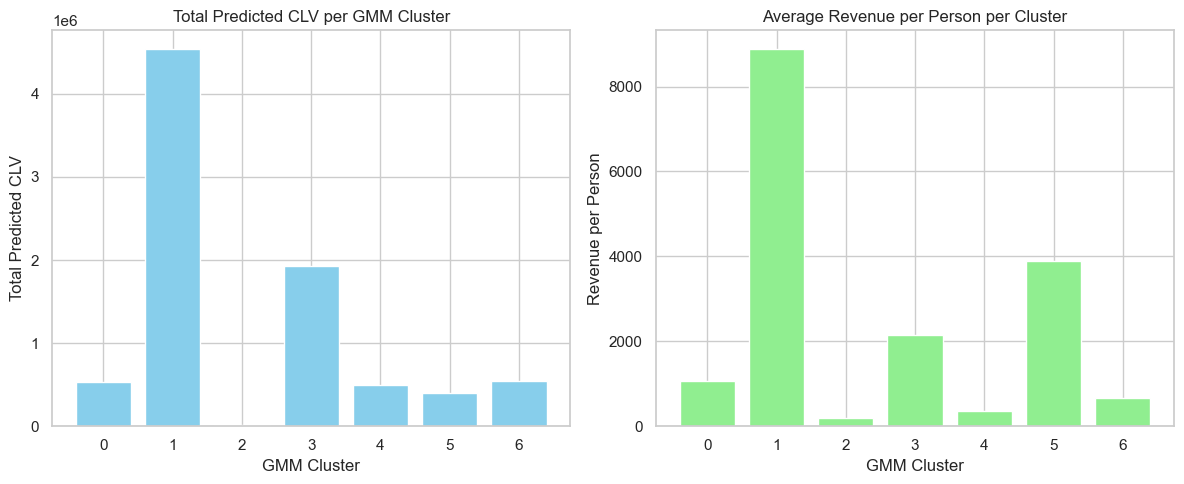

In [22]:
numeric_cols = ['Recency','Frequency','Monetary','AOV','Tenure']

# Apply same log transform as training (if model was trained on log y, skip if y was original)
rfm_clustered_transformed = rfm_clustered.copy()
for col in numeric_cols:
    rfm_clustered_transformed[col] = np.log1p(rfm_clustered_transformed[col])

# Standardize features using the same scaler as training
rfm_clustered_scaled = scaler.transform(rfm_clustered_transformed[numeric_cols])

# Predict using best GB model (trained on original y)
y_pred = best_gb.predict(rfm_clustered_scaled)  # predicted CLV in normal domain

# Add predicted CLV as new column
rfm_clustered['CLV'] = y_pred

# Total CLV per cluster
cluster_totals = rfm_clustered.groupby('GMM_Cluster')['CLV'].sum().reset_index()
cluster_totals.rename(columns={'CLV':'Total_CLV'}, inplace=True)

# Total revenue per person per cluster
cluster_totals['Revenue_per_Person'] = rfm_clustered.groupby('GMM_Cluster')['CLV'].mean().values

# Calculate percentage contribution
total_clv_sum = cluster_totals['Total_CLV'].sum()
cluster_totals['Pct_Contribution'] = (cluster_totals['Total_CLV'] / total_clv_sum * 100).round(2)

# Sort by cluster
cluster_totals = cluster_totals.sort_values('GMM_Cluster').reset_index(drop=True)

# Display table
print(cluster_totals)

# Plot subplots: Total CLV and Revenue per Person
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Total Predicted CLV
axes[0].bar(cluster_totals['GMM_Cluster'].astype(str), cluster_totals['Total_CLV'], color='skyblue')
axes[0].set_xlabel("GMM Cluster")
axes[0].set_ylabel("Total Predicted CLV")
axes[0].set_title("Total Predicted CLV per GMM Cluster")

# Revenue per Person
axes[1].bar(cluster_totals['GMM_Cluster'].astype(str), cluster_totals['Revenue_per_Person'], color='lightgreen')
axes[1].set_xlabel("GMM Cluster")
axes[1].set_ylabel("Revenue per Person")
axes[1].set_title("Average Revenue per Person per Cluster")

plt.tight_layout()
plt.savefig("PredictedCLV_and_RevenuePerPerson.png")
plt.show()

